In [60]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from datetime import datetime as dt
import os
from tqdm import tqdm_notebook as tqdm

def getNow():
    now       = dt.now().strftime('%Y-%m-%d--%H-%M-%S')
    nowFolder = os.path.join('./logFolder', now)
    return nowFolder

We shall first create a fairly nonlinear function in two dimensions $x_1$ and $x_2$. The resultant function $z$ will be predicted with a neural network. However, to test the uncertainity of the network, we are going to 

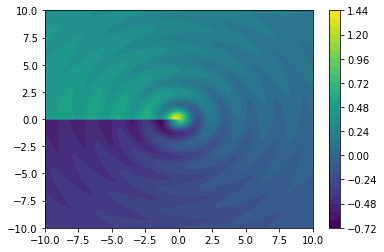

In [3]:
X1, Y1 = np.meshgrid(np.linspace(-10, 10, 200), np.linspace(-10, 10, 200))
R = np.sqrt(X1**2 + Y1**2)
Z1 = np.sinc(R) + np.arctan2(Y1,X1)/(np.pi*2)
plt.contourf( X1,Y1, Z1, levels=30)
plt.colorbar()
plt.show()
plt.close('all')

For the purposes of training, we shall extract out the region where $x_1 > -5$ and provide that as training data. During prediction, we shall see what the standard deviation is when we predict with dropout multiple times.

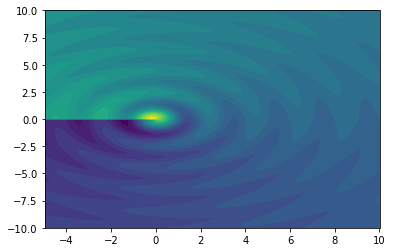

In [34]:
mask = X1 > -5
Xtrain, Ytrain, Ztrain = X1[mask].reshape((200, -1)), Y1[mask].reshape((200, -1)), Z1[mask].reshape((200, -1))

plt.contourf(Xtrain, Ytrain, Ztrain, levels=30)
plt.show()
plt.close('all')

trainX = np.vstack((Xtrain.flatten(), Ytrain.flatten())).T
trainY = Ztrain.flatten().reshape((-1, 1))

predictX = np.vstack((X1.flatten(), Y1.flatten())).T
predictY = Z1.flatten().reshape((-1, 1))

Create a simple neural network structure and train it to the data ...

In [63]:
layers     = [200, 200, 100, 50, 10, 1]
dropout    = [0.1, 0.1 , 0.1, 0.1, 0.1, 0]
activation = [tf.nn.relu, tf.nn.relu, tf.nn.relu, tf.nn.relu, tf.nn.relu, None]

# Generate the graph
tf.reset_default_graph()

X = tf.placeholder(tf.float32, (None, 2), 'X')
y = tf.placeholder(tf.float32, (None, 1), 'y')
training = tf.placeholder(tf.bool, (), 'training')

lastL = 2

yHat = X * 1
for i, (l, a, d) in enumerate(zip(layers, activation, dropout)):
    
    with tf.variable_scope(f'layer_{i}'):
        W = tf.Variable( (np.random.randn(lastL, l)*0.1).astype(np.float32) )
        b = tf.Variable( (np.random.randn(l, )*0.1).astype(np.float32) )

        yHat = (yHat @ W + b)
        if a is not None:
            yHat = a(yHat)
            yHat = tf.layers.dropout(yHat, rate=d, training=training)

    lastL = l
    
err = tf.reduce_mean((y - yHat)**2)
opt = tf.train.AdamOptimizer(learning_rate=0.01).minimize(err)
init = tf.global_variables_initializer()


In [89]:
folder = getNow()

errVals = []
with tf.Session() as sess:
    writer = tf.summary.FileWriter(folder, sess.graph)
    sess.run(init)
    
    for i in tqdm(range(500)):
        _, errVal = sess.run([opt, err], feed_dict={
            X : trainX.astype(np.float32),
            y : trainY.astype(np.float32),
            training: True
             })
        errVals.append(errVal)

    # Prediciton without dropout
    # ---------------------------------
    tempErrs = []
    for i in tqdm(range(100)):
        errVal = sess.run( err, feed_dict={
            X : trainX.astype(np.float32),
            y : trainY.astype(np.float32),
            training: False
             })
        tempErrs.append(errVal)
    
    tempErrs = np.array( tempErrs ) 
    print(f'In testing mode: {tempErrs.mean(), tempErrs.std()}')
    yHatNoDropout = sess.run( yHat, feed_dict={
            X : predictX.astype(np.float32),
            training: False
             })
        
        
    # Prediciton with dropout
    # ---------------------------------
    tempErrs = []
    for i in tqdm(range(100)):
        errVal = sess.run( err, feed_dict={
            X : trainX.astype(np.float32),
            y : trainY.astype(np.float32),
            training: True
             })
        tempErrs.append(errVal)
    
    tempErrs = np.array( tempErrs ) 
    print(f'In training mode: {tempErrs.mean(), tempErrs.std()}')
    
    # Predicting with 
    # ---------------------------------
    yHats = []
    for i in tqdm(range(100)):
        yHatVal = sess.run( yHat, feed_dict={
            X : predictX.astype(np.float32),
            training: True
             })
        yHats.append(yHatVal.reshape(200, -1))
    
    writer.close()

    



In testing mode: (0.0011381563, 2.3283064e-10)



In training mode: (0.0033477051, 4.7964983e-05)


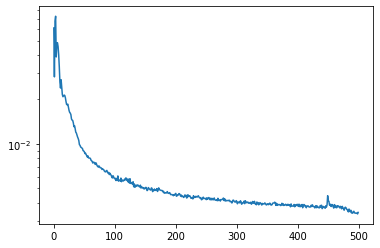

In [90]:
plt.plot(errVals)
plt.yscale('log')
plt.show()
plt.close('all')

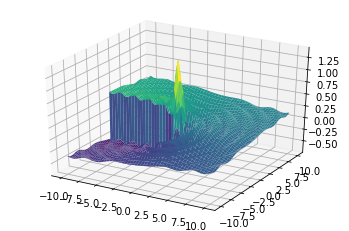

In [91]:
from mpl_toolkits.mplot3d import Axes3D
#-------------------------------------------------
# This is the original data we are trying to predict
#-------------------------------------------------

fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X1, Y1, Z1, cmap=plt.cm.viridis , linewidth=0)
plt.show()
plt.close('all')

In [93]:
yHatNoDropout.shape

(40000, 1)

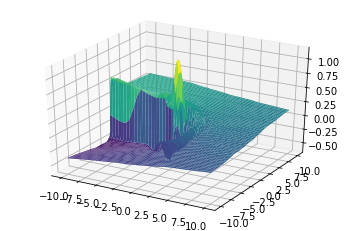

In [99]:
# ---------------------------------------------
# This is the prediction with
# dropout turned off - this is the only prediction
# that we have from this model
# ----------------------------------------------
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X1, Y1, yHatNoDropout.reshape(200,-1), cmap=plt.cm.viridis , linewidth=0 )
plt.show()
plt.close('all')

In [80]:
yHats1 = np.array(yHats)

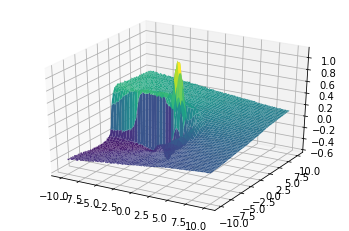

In [100]:
# ---------------------------------------------
# This is the mean of the 100 prediciotns with 
# dropout turned on - this is our expectation
# of the prediction
# ----------------------------------------------
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X1, Y1, yHats1.mean(axis=0), cmap=plt.cm.viridis , linewidth=0 )
plt.show()
plt.close('all')

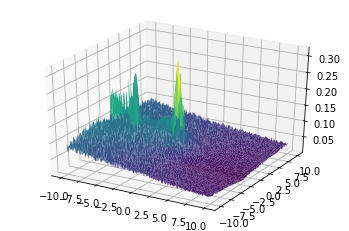

In [101]:
# ---------------------------------------------
# This is the std of the 100 predictions with 
# dropout turned on. This is our estimation of the
# error
# Notice that the std increases in the X-direction
# before X = -5 because we have not proovided 
# training data in that region
# ----------------------------------------------
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X1, Y1, yHats1.std(axis=0), cmap=plt.cm.viridis , linewidth=0)
plt.show()
plt.close('all')